In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

In [3]:
# 321300
df = pd.read_csv('/content/air_quality_data_preprocessed.csv')
df.shape

(31800, 33)

In [4]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,16,2013,3,1,15,8.0,15.0,7.0,14.0,400.0,...,77.0,7.395833,6.500000,12.890625,22.265625,3141.176471,77.0,6,3141.0,Severe
1,17,2013,3,1,16,9.0,19.0,9.0,13.0,400.0,...,77.0,7.843137,7.235294,12.794118,21.911765,2552.941176,77.0,6,2553.0,Severe
2,18,2013,3,1,17,10.0,23.0,11.0,15.0,400.0,...,77.0,8.333333,8.111111,12.847222,21.736111,2552.941176,77.0,6,2553.0,Severe
3,19,2013,3,1,18,11.0,20.0,8.0,20.0,500.0,...,77.0,8.859649,8.736842,12.697368,21.907895,3141.176471,77.0,6,3141.0,Severe
4,20,2013,3,1,19,8.0,14.0,12.0,30.0,500.0,...,77.0,9.083333,9.000000,12.812500,22.687500,3141.176471,77.0,6,3141.0,Severe


In [12]:
train = df[:28000]['AQI_calculated']
test = df[28000:31800]['AQI_calculated']

In [13]:
# Normalizing training data # Converted into array as all the methods available are for arrays and not lists
train = np.asarray(train)
train_norm = np.reshape(train, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)

#Printing
for i in range(5):
    print(train_norm[i])

[0.04040456]
[0.03030771]
[0.03030771]
[0.04040456]
[0.04040456]


In [14]:
train_norm = train_norm[train_norm!=0]

In [16]:
# Normalizing testing data # Converted into array as all the methods available are for arrays and not lists
test = np.asarray(test)
test_norm = np.reshape(test, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)

#Printing
for i in range(5):
    print(test_norm[i])

[0.12121368]
[0.12121368]
[0.10101999]
[0.10101999]
[0.10101999]


In [17]:
test_norm = test_norm[test_norm != 0]

In [18]:
print(train_norm.shape)
print(test_norm.shape)

(27996,)
(3797,)


In [19]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x),array(y)

In [20]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
for i in range(5):
    print(X_split_train[i], y_split_train[i])

[0.04040456 0.03030771 0.03030771] 0.04040456075279896
[0.03030771 0.03030771 0.04040456] 0.04040456075279896
[0.03030771 0.04040456 0.04040456] 0.05050140806374064
[0.04040456 0.04040456 0.05050141] 0.05050140806374064
[0.04040456 0.05050141 0.05050141] 0.06061542688371454


In [21]:
print(X_split_train.shape[0])
print(X_split_train.shape[1])
print(X_split_train.shape)

27993
3
(27993, 3)


In [22]:
print(X_split_train[0])

[0.04040456 0.03030771 0.03030771]


In [23]:
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train[i])

[[0.04040456]
 [0.03030771]
 [0.03030771]]
[[0.03030771]
 [0.03030771]
 [0.04040456]]
[[0.03030771]
 [0.04040456]
 [0.04040456]]
[[0.04040456]
 [0.04040456]
 [0.05050141]]
[[0.04040456]
 [0.05050141]
 [0.05050141]]


In [24]:
print(X_split_train.shape)

(27993, 3, 1)


In [25]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])

[0.12121368 0.12121368 0.10101999] 0.1010199876365135
[0.12121368 0.10101999 0.10101999] 0.1010199876365135
[0.10101999 0.10101999 0.10101999] 0.1010199876365135
[0.10101999 0.10101999 0.10101999] 0.1010199876365135
[0.10101999 0.10101999 0.10101999] 0.13131052956933856


In [26]:
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))
for i in range(5):
    print(X_split_test[i])

[[0.12121368]
 [0.12121368]
 [0.10101999]]
[[0.12121368]
 [0.10101999]
 [0.10101999]]
[[0.10101999]
 [0.10101999]
 [0.10101999]]
[[0.10101999]
 [0.10101999]
 [0.10101999]]
[[0.10101999]
 [0.10101999]
 [0.10101999]]


In [27]:
print(X_split_test.shape)

(3794, 3, 1)


In [28]:
# Reshape the input data to have 2 dimensions
X_split_train_2d = X_split_train.reshape(X_split_train.shape[0], -1)
for i in range(5):
    print(X_split_train_2d[i])

[0.04040456 0.03030771 0.03030771]
[0.03030771 0.03030771 0.04040456]
[0.03030771 0.04040456 0.04040456]
[0.04040456 0.04040456 0.05050141]
[0.04040456 0.05050141 0.05050141]


In [29]:
# Reshape the input data to have 2 dimensions
X_split_test_2d = X_split_test.reshape(X_split_test.shape[0], -1)
for i in range(5):
    print(X_split_test_2d[i])

[0.12121368 0.12121368 0.10101999]
[0.12121368 0.10101999 0.10101999]
[0.10101999 0.10101999 0.10101999]
[0.10101999 0.10101999 0.10101999]
[0.10101999 0.10101999 0.10101999]


In [30]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
from sklearn.metrics import r2_score

In [31]:
import tensorflow.keras.backend as K

In [32]:
def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred))

#**GRU I**

In [33]:
# design network

regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_split_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_split_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_split_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=[msle])
regressorGRU.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 3, 50)               │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 3, 50)               │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 3, 50)               │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Fitting to the training set
hist = regressorGRU.fit(X_split_train,y_split_train, validation_data=(X_split_test, y_split_test), epochs=50,batch_size=64, verbose = 1)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0181 - mean_squared_logarithmic_error: 0.0111 - val_loss: 0.0084 - val_mean_squared_logarithmic_error: 0.0042
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0034 - mean_squared_logarithmic_error: 0.0019 - val_loss: 0.0028 - val_mean_squared_logarithmic_error: 0.0017
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0025 - mean_squared_logarithmic_error: 0.0015 - val_loss: 0.0029 - val_mean_squared_logarithmic_error: 0.0017
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0024 - mean_squared_logarithmic_error: 0.0014 - val_loss: 0.0028 - val_mean_squared_logarithmic_error: 0.0017
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0024 - mean_squared_logarithmic_error: 0.0015 - val_loss: 0.0029 - val_mean_squared_logarithmic_error: 0.0017
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0024 - mean_squared_logarithmic_error: 0.0014 - val_loss: 0.0028 - v

#**--------------------------**

In [35]:
yhat = regressorGRU.predict(X_split_test)
for i in range(5):
    print(yhat[i])

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
[0.12765634]
[0.12046541]
[0.11273202]
[0.11273202]
[0.11273202]


In [36]:
mse = mean_squared_error(y_split_test, yhat)
rmse = sqrt(metrics.mean_squared_error(y_split_test, yhat))
mae= metrics.mean_absolute_error(y_split_test, yhat)
r2= metrics.r2_score(y_split_test, yhat)

print('MSE: %.5f' % mse)
print('RMSE: %.5f' % rmse)
print('MAE: %.5f' % mae)
print('R2: %.5f' % r2)

MSE: 0.00259
RMSE: 0.05093
MAE: 0.02932
R2: 0.93185


In [37]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 25 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

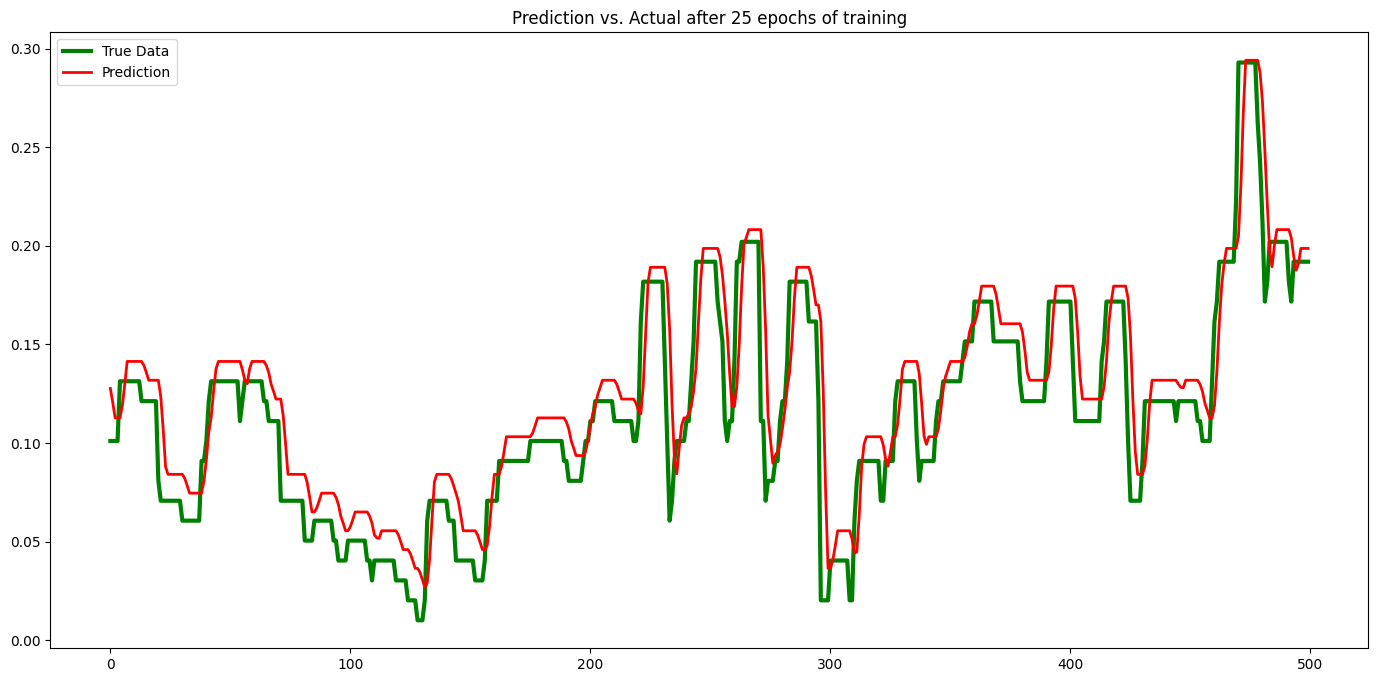

In [38]:
plot_predicted(yhat[:500,], y_split_test[:500,])

In [ ]:
_, train_acc = regressorGRU.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = regressorGRU.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.00041, Test: 0.00025


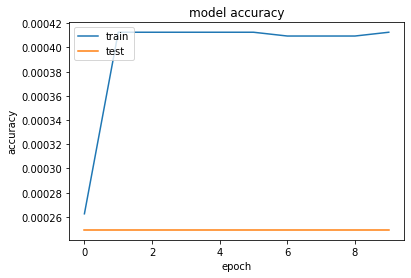

In [ ]:
# Resolve the issue

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

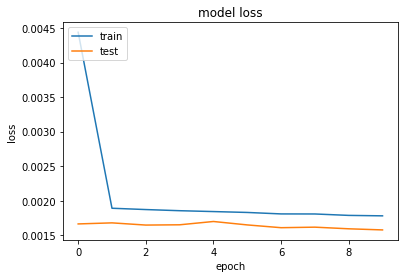

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**--------------------------**

In [ ]:
yhat = regressorGRU.predict(X_split_test)
for i in range(5):
    print(yhat[i])

2508/2508 [==============================] - 8s 3ms/step
[0.12206972]
[0.12027628]
[0.12027628]
[0.12027628]
[0.12027628]


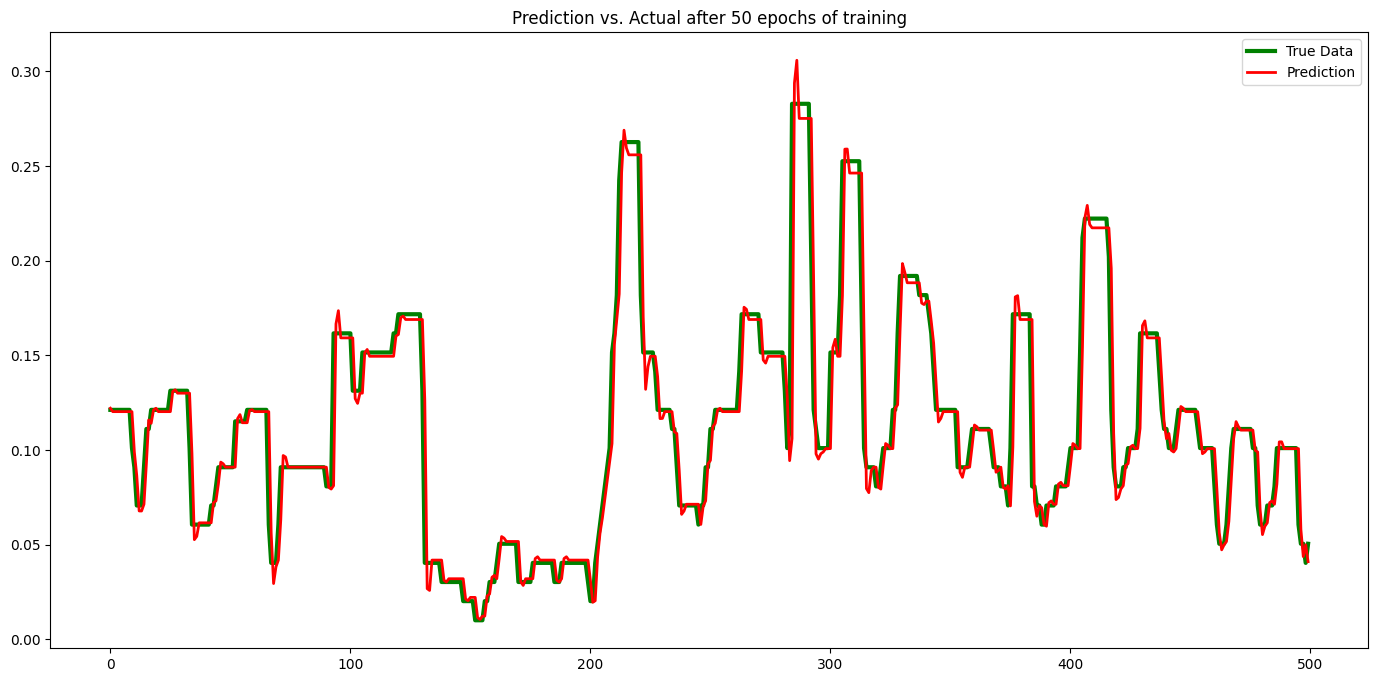

In [ ]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 50 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

plot_predicted(yhat[:500,], y_split_test[:500,])

In [ ]:
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_split_test[:64252,], yhat[:64252,])
#rmsle = rmsle_custom(y_split_test[:64252,], yhat[:64252,])
#msle = mean_squared_log_error(y_split_test[:64252,], yhat[:64252,])
mae = mean_absolute_error(y_split_test[:64252,], yhat[:64252,])
rmse = math.sqrt(mse)

print('Mean Squared Error: %.5f' % mse)
# print('Root Mean Squared Logarithmic Error: %.5f' % rmsle)
#print('Mean Squared Logarithmic Error: %.5f' % msle)
print('Mean Absolute Error: %.5f' % mae)
print('Root Mean Squared Error: %.5f' % rmse)

Mean Squared Error: 0.00060
Mean Absolute Error: 0.01116
Root Mean Squared Error: 0.02460


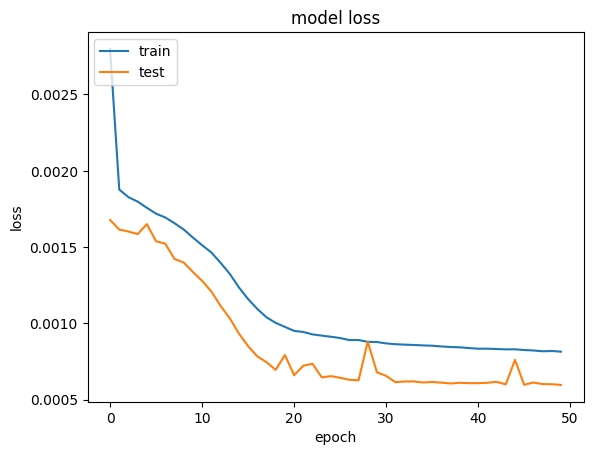

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

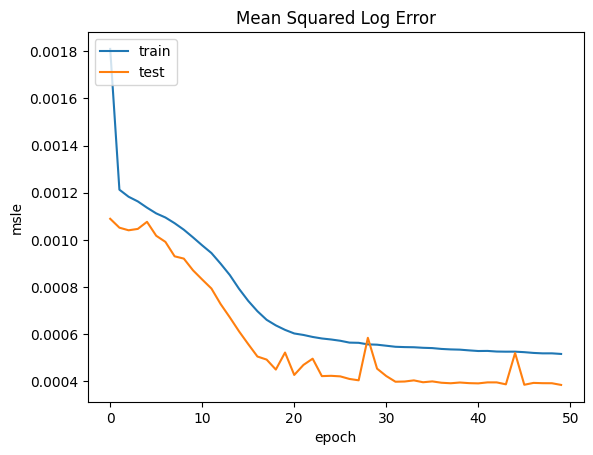

In [ ]:
plt.plot(hist.history['mean_squared_logarithmic_error'])
plt.plot(hist.history['val_mean_squared_logarithmic_error'])
plt.title('Mean Squared Log Error')
plt.ylabel('msle')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()